# Laboratorio 2 - Data Science

In [9]:
!pip install --upgrade pip
!pip install --upgrade numpy tensorflow
!pip install numpy==1.23.5

  Using cached numpy-2.3.2-cp311-cp311-win_amd64.whl.metadata (60 kB)
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
    --------------------------------------- 0.3/14.6 MB ? eta -:--:--
    --------------------------------------- 0.3/14.6 MB ? eta -:--:--
    --------------------------------------- 0.3/14.6 MB ? eta -:--:--
    ----------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
scipy 1.16.0 requires numpy<2.6,>=1.25.2, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.


In [2]:
import numpy as np
import tensorflow as tf

(X_entreno, y_entreno), (X_prueba, y_prueba) = tf.keras.datasets.mnist.load_data()
X_entreno.shape

C:\Users\JM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.25.2 and <2.6.0 is required for this version of SciPy (detected version 1.23.5)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


(60000, 28, 28)

In [3]:
assert X_entreno.shape == (60000, 28, 28)
assert X_prueba.shape == (10000, 28, 28)
assert y_entreno.shape == (60000,)
assert y_prueba.shape == (10000,)

In [4]:
num_obs_validacion = y_prueba.shape[0]
num_obs_prueba = y_prueba.shape[0]


In [5]:
X_entreno_normalizado = X_entreno / 255
X_prueba_normalizado = X_prueba / 255

In [6]:
X_validacion = X_entreno_normalizado[-num_obs_validacion: , : , : ]
y_validacion = y_entreno[-num_obs_validacion:]

In [7]:
X_entreno = X_entreno_normalizado[ : X_entreno_normalizado.shape[0] - num_obs_validacion, : , : ]
y_entreno = y_entreno[ : y_entreno.shape[0] - num_obs_validacion]
num_obs_entreno = y_entreno.shape[0]

In [23]:
BATCH_SIZE = 100
datos_entreno = tf.data.Dataset.from_tensor_slices((X_entreno, y_entreno))
datos_validacion = tf.data.Dataset.from_tensor_slices((X_validacion, y_validacion))
datos_prueba = tf.data.Dataset.from_tensor_slices((X_prueba, y_prueba))

datos_entreno = datos_entreno.shuffle(buffer_size = num_obs_entreno).batch(BATCH_SIZE)
datos_validacion = datos_validacion.batch(BATCH_SIZE)
datos_prueba = datos_prueba.batch(BATCH_SIZE)


## Modelo

In [58]:
# Vars constantes
from matplotlib import pyplot as plt
import time
NUM_EPOCHS = 20

class RNN():
    def __init__(
            self,
            entrada,
            salida,
            capa_escondida,
        ):
        self.entrada = entrada
        self.salida = salida
        self.capa_escondida = capa_escondida
        
        self.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            
            tf.keras.layers.Dense(capa_escondida, activation='relu'), # 2nda capa escondida

            tf.keras.layers.Dense(salida, activation='softmax') # capa salida
        ])
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    def train(self, train_data, validation_data, num_epochs, verbose=0):
        start_time = time.time()
        self.history = self.model.fit(
            train_data,
            epochs = num_epochs, 
            validation_data = validation_data,
            verbose = verbose
        )
        end_time = time.time()
        train_loss = self.history.history['loss'][-1]
        train_acc = self.history.history['accuracy'][-1]
        val_loss = self.history.history['val_loss'][-1]
        val_acc = self.history.history['val_accuracy'][-1]
        t_time = end_time - start_time
        return (train_loss, train_acc, val_loss, val_acc, t_time)
    
    def test(self, test_data):
        loss, accuracy = self.model.evaluate(test_data)
        return (loss, accuracy)
    
    def plot_accuracy(self, title):
        plt.plot(self.history.history['accuracy'], label="Train")
        plt.plot(self.history.history['val_accuracy'], label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def plot_loss(self, title):
        plt.plot(self.history.history['loss'], label="Train")
        plt.plot(self.history.history['val_loss'], label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()

## 1. Modular Neuronas de capas internas

In [59]:
# iterar por cada una de las topologias
performance_1 = [] # almacenamiento de resultados

for inner_size in [50, 100, 200, 300, 500]:
    # Inicializar RNN
    m1 = RNN(784, 10, inner_size)
    # Compilar otpimizador
    m1.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Metricas de etrenamiento
    (e_loss, e_acc, _, _, t_time) = m1.train(datos_entreno, datos_validacion, num_epochs=20)
    # Metricas de prueba
    t_loss, t_acc = m1.test(datos_prueba)
    performance_1.append({"Ancho": inner_size, "e_loss": e_loss, "e_acc": e_acc, "t_loss": t_loss, "t_acc": t_acc, "training_time": t_time})
    print(f"finished for inner size {inner_size}")
    

C:\Users\JM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9714 - loss: 19.2333   
finished for inner size 50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9755 - loss: 20.2850
finished for inner size 100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9792 - loss: 18.0024
finished for inner size 200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9803 - loss: 17.7231  
finished for inner size 300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9812 - loss: 17.6131
finished for inner size 500


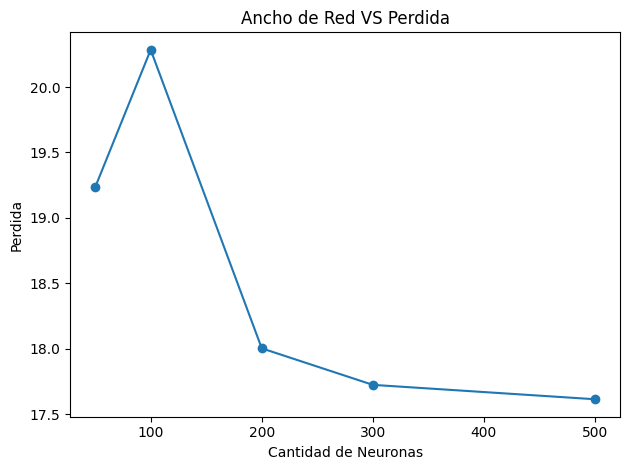

In [64]:
import pandas as pd
df1 = pd.DataFrame(performance_1)
plt.title("Ancho de Red VS Perdida")
plt.plot(df1["Ancho"], df1["t_loss"], '-o')
plt.xlabel("Cantidad de Neuronas")
plt.ylabel("Perdida")
plt.tight_layout()
plt.show()

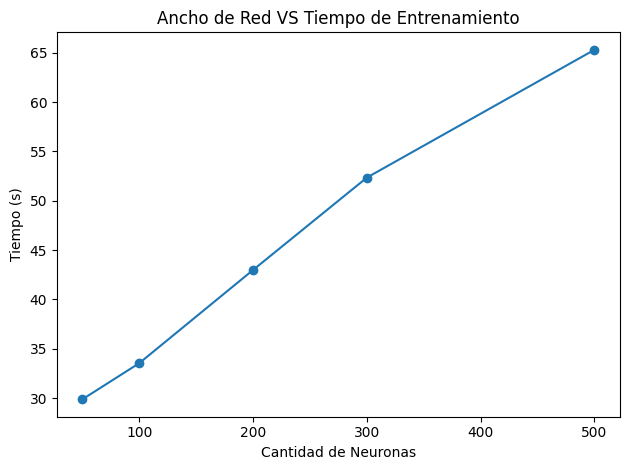

In [67]:
plt.title("Ancho de Red VS Tiempo de Entrenamiento")
plt.plot(df1["Ancho"], df1["training_time"], '-o')
plt.xlabel("Cantidad de Neuronas")
plt.ylabel("Tiempo (s)")
plt.tight_layout()
plt.show()

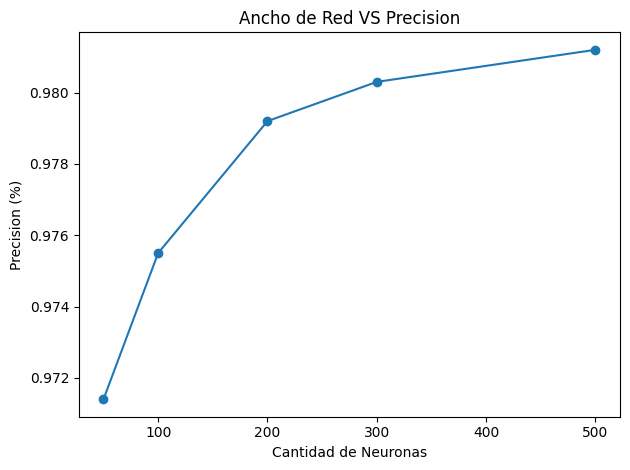

In [69]:
plt.title("Ancho de Red VS Precision")
plt.plot(df1["Ancho"], df1["t_acc"], '-o')
plt.xlabel("Cantidad de Neuronas")
plt.ylabel("Precision (%)")
plt.tight_layout()
plt.show()